In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

## HYPOTHESIS TESTING
**Question 1:** Do customers with varying levels of engagement with the bank have significantly different probabilities of churn and what does this tell us about the measures of engagement which matter the most?

**Approach:** Define customer profiles based on three measures of engagement (NumOfProducts, IsActiveMember and Tenure), and then implement hypothesis testing to see if churn proportion is significantly different from one profile to another.

In [3]:
# Customer Profiling #

# First Profile - Product Drivenness #
# Test H0: P(churn)_prod-driven = P(churn)_normal
# and  H1: P(churn)_prod-driven < P(churn)_normal
dataset = pd.read_csv("Churn_Modelling.csv")
colnames = dataset.columns

sample_vpd_churn = len(dataset[(dataset['NumOfProducts'] >= 3) & (dataset['Exited'] == 1)])
sample_size_vpd = len(dataset[(dataset['NumOfProducts'] >= 3)])

sample_normal_churn = len(dataset[(dataset['NumOfProducts'] < 3) & (dataset['Exited'] == 1)])
sample_size_normal = len(dataset[(dataset['NumOfProducts'] < 3)])

churns = np.array([sample_vpd_churn, sample_normal_churn])
samples = np.array([sample_size_vpd, sample_size_normal])

stat, p_value = proportions_ztest(count=churns, nobs=samples, alternative='larger')
print(p_value)
# p ~ 0; reject null

2.9185852464596694e-196


In [4]:
# Second Profile - "Activeness", as measured by bank #
# Test H0: P(churn)_active = P(churn)_notactive
# Test H1: P(churn)_active < P(churn)_notactive

sample_active_churn = len(dataset[(dataset['IsActiveMember'] == 1) & (dataset['Exited'] == 1)])
sample_size_active = len(dataset[(dataset['IsActiveMember'] == 1)])

sample_notactive_churn = len(dataset[(dataset['IsActiveMember'] == 0) & (dataset['Exited'] == 1)])
sample_size_notactive = len(dataset[(dataset['IsActiveMember'] == 0)])

churns = np.array([sample_active_churn, sample_notactive_churn])
samples = np.array([sample_size_active, sample_size_notactive])

stat, p_value = proportions_ztest(count=churns, nobs=samples, alternative = 'smaller')
print(p_value)
# p ~ 0; reject null

2.9769262701820924e-55


In [5]:
# Third Profile - Tenure #
# Test H0: P(churn)_established = P(churn)_new
# Test H1: P(churn)_established < P(churn)_new

cutoff = 1
# tried different cutoffs for new vs. established classification
# cutoff of 1 yr yields most significant p_value, which is still 0.01
# and above our threshold of significance (0.005)
# Conclusion: tenure not a great measure of engagement to predict churn with

sample_established_churn = len(dataset[(dataset['Tenure'] > cutoff) & (dataset['Exited'] == 1)])
sample_size_established = len(dataset[(dataset['Tenure'] > cutoff)])

sample_new_churn = len(dataset[(dataset['Tenure'] <= cutoff) & (dataset['Exited'] == 1)])
sample_size_new = len(dataset[(dataset['Tenure'] <= cutoff)])

churns = np.array([sample_established_churn, sample_new_churn])
samples =np.array([sample_size_established, sample_size_new])

stat, p_value = proportions_ztest(count=churns, nobs=samples, alternative='smaller')
print(p_value)
# p = 0.01; do not reject null

0.011884065776476273


## CORRELATION TESTING
**Question 2:** Of our numerical features (Age, estimated salary, balance, etc.), are there any that are highly correlated / duplicative that we should consolidate or remove prior to developing a predictive churn model?

**Approach:**
1. Compute the correlation matrix for the data and determine if any features are highly correlated with one another, or if any features correlate highly with the target variable "Exited".
2. Perform PCA on the dataset and generate a Scree plot to determine how much explained variance we have in each principal component.

In [130]:
churn = pd.read_csv('Churn_Modelling.csv', index_col=0)

<AxesSubplot:>

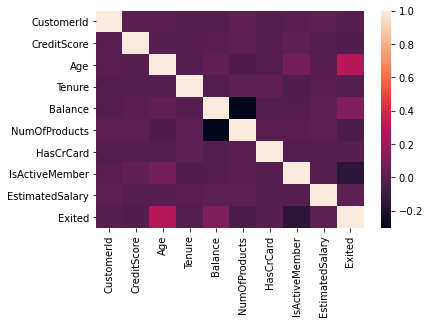

In [131]:
sn.heatmap(churn.corr())

In [132]:
churn_clean = churn.copy()

In [133]:
categorical_cols = {'Geography', 'Gender'}
predict_cols = set((churn.columns)) - {'CustomerId', 'Exited', 'Surname'}
num_cols = predict_cols- categorical_cols

In [134]:
sclr = StandardScaler()
lblr = LabelEncoder()
sclr.fit(churn[num_cols])
for col in categorical_cols:
    churn_clean[col] = lblr.fit_transform(churn[col])
churn_clean[list(num_cols)] = sclr.transform(churn[num_cols])

<AxesSubplot:>

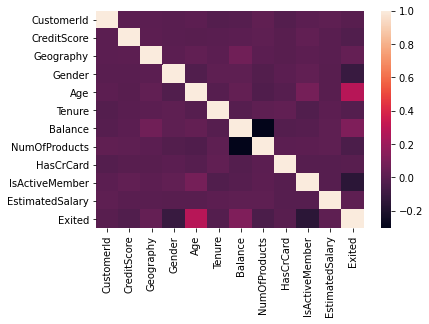

In [135]:
sn.heatmap(churn_clean.corr())

In [136]:
churn_clean.head(2)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,-0.326221,0,0,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,1
2,15647311,Hill,-0.440036,2,0,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,0


In [137]:
pca = PCA().fit(churn_clean[predict_cols])

Text(0, 0.5, 'cumulative explained variance')

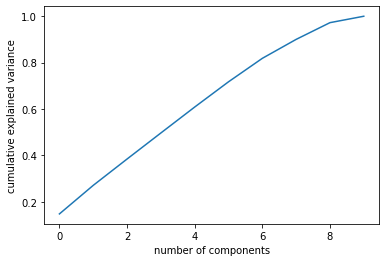

In [138]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

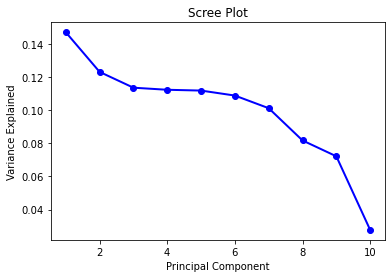

In [139]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## MODELING
**Question 3:** Using the contributing factors that we identified in our previous analyses, how accurately can we predict customer churn, and what are the most important contributing factors overall?

**Approach:**
1. Feature selection using Boruta - algorithm determines whether each feature contributes significantly to model performance, allowing us to select a smaller subset of features. This is beneficial in terms of model training time and interpretability.
2. Data preparation for modeling - 80-20 train / test split and standardization (if needed).
3. Model implementation - we optimize and compare the following supervised classification models based on their F1 scores on the testing (holdout) data:
    - Logistic Regression
    - K-Nearest Neighbors
    - Support Vector Machine
    - Random Forest

**Conclusion:**
From modeling experimentation, we find that Random Forest predicts churn with the highest F1 score (0.60). Since Random Forest allows us to determine feature importance, we also compute relative feature importances to determine the most important contributing factors to customer churn.


In [140]:
#########################
### FEATURE SELECTION ###
#########################

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

### Initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 7, 
   verbose = 0
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 500, # number of trials to perform, 
   verbose = 0
)
### modify datatype for Boruta (it accepts np.array, not pd.DataFrame)

## NOTE: Omitted Surname and Customer ID
churn_data_x = churn_clean[list(predict_cols)]
churn_data_y = churn_clean[['Exited']]

churn_data_x_numpy = churn_data_x.to_numpy()
churn_data_y_numpy = churn_data_y.to_numpy()

## Boruta has already been run so for future runs of this notebook we avoid a re-run
## To re-run Boruta, switch runBoruta to True
runBoruta = False

if runBoruta:
    boruta.fit(churn_data_x_numpy, churn_data_y_numpy)

    ## Green Area variables have been cleared as significant, blue area variables are still uncertain
    green_area = churn_data_x.columns[boruta.support_].to_list()
    blue_area = churn_data_x.columns[boruta.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)
else:
   green_area = ['Age', 'EstimatedSalary', 'CreditScore', 'Geography', 'NumOfProducts', 'IsActiveMember', 'Balance']
   blue_area = []

In [ ]:
!pip install imblearn

In [ ]:
############################################
### PREPARATION FOR MODEL IMPLEMENTATION ###
############################################

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import linear_model

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 80-20 Train Test Split
x_train, x_test, y_train, y_test = train_test_split(churn_data_x[green_area], churn_data_y, test_size = 0.2, random_state = 20)
smt = SMOTE(random_state=0)

# For trying SMOTE to address class imbalance
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(x_train, y_train)

# Standardize data for models that need it
X_train_scaled = StandardScaler().fit_transform(x_train)
X_test_scaled = StandardScaler().fit_transform(x_test)
X_train_SMOTE_scaled = StandardScaler().fit_transform(X_train_SMOTE)


Training accuracy:  0.80575
Testing accuracy:  0.815
F1 score:  0.2884615384615385


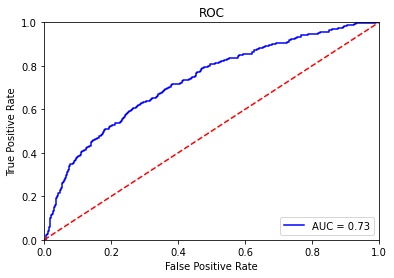

Training accuracy (balanced):  0.7
------------------------------------------------
Final Results on Test Data:
              precision    recall  f1-score   support

           0       0.90      0.70      0.78      1617
           1       0.34      0.66      0.45       383

    accuracy                           0.69      2000
   macro avg       0.62      0.68      0.62      2000
weighted avg       0.79      0.69      0.72      2000



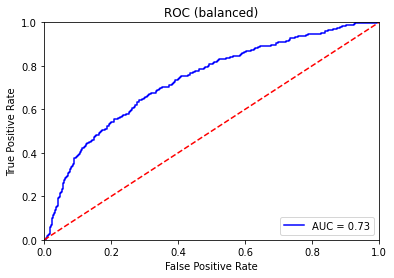

In [147]:
#################################################
### MODEL IMPLEMENTATION, LOGISTIC REGRESSION ###
#################################################

features = churn_clean[green_area]
exited = churn_clean['Exited']

features_train, features_test, exited_train, exited_test = train_test_split(features, exited, test_size=0.20)

#regression without balanced class weights
logistic_reg = linear_model.LogisticRegression().fit(features_train, exited_train)
print('Training accuracy: ', logistic_reg.score(features_train, exited_train))
print('Testing accuracy: ', logistic_reg.score(features_test, exited_test))
print('F1 score: ', f1_score(exited_test, logistic_reg.predict(features_test)))

probs = logistic_reg.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(exited_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#regression with balanced class weights
logistic_reg_balanced = linear_model.LogisticRegression(class_weight='balanced').fit(features_train, exited_train)
print('Training accuracy (balanced): ', logistic_reg_balanced.score(features_train, exited_train))
print('------------------------------------------------')
print('Final Results on Test Data:')
print(classification_report(exited_test, logistic_reg_balanced.predict(features_test)))

probs_balanced = logistic_reg_balanced.predict_proba(features_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced, tpr_balanced, threshold_balanced = metrics.roc_curve(exited_test, preds_balanced)
roc_auc_balanced = metrics.auc(fpr_balanced, tpr_balanced)

plt.title('ROC (balanced)')
plt.plot(fpr_balanced, tpr_balanced, 'b', label = 'AUC = %0.2f' % roc_auc_balanced)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [153]:
#################################################
### MODEL IMPLEMENTATION, K-NEAREST NEIGHBORS ###
#################################################

# Baseline Model Performance
knn = KNeighborsClassifier(n_neighbors=5) # KNN on default settings set by sklearn
knn_baseline_scores = cross_val_score(knn, X_train_scaled, np.array(y_train).ravel(), scoring='f1') #note: np.array(y_train) was to remove warnings, y_train on its own also works
print('KNN 5-fold average baseline: {}\n'.format(knn_baseline_scores.mean()))

# Parameter ranges in sklearn's KNN algorithm method for hyperparameter tuning using Grid Search
n_neighbors = list(range(2,10))
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
p = [1, 2]

knn_grid = {
        'n_neighbors': n_neighbors,
        'weights': weights,
        'algorithm': algorithm,
        'p': p
       }

# Run GridSearchCV to obtain optimal hyperparameters for KNN
knn_gs = GridSearchCV(estimator = knn, param_grid = knn_grid, cv = 5, n_jobs = -1)
knn_gs.fit(X_train_scaled, np.array(y_train).ravel())
print('Best Params (without SMOTE):', knn_gs.best_params_)

knn_gs.fit(X_train_SMOTE_scaled, np.array(y_train_SMOTE).ravel())
print('Best Params (with SMOTE):\n', knn_gs.best_params_)

# Evaluate optimized models on training set using CV 
knn_best = KNeighborsClassifier(algorithm='auto', n_neighbors=9, p=2, weights='uniform')
knn_opt_scores = cross_val_score(knn_best, X_train_scaled, np.array(y_train).ravel(), scoring='f1')
print('KNN 5-fold average f1 after hyperparameter tuning: {}\n'.format(knn_opt_scores.mean()))

knn_best_SMOTE = KNeighborsClassifier(algorithm='auto', n_neighbors=2, p=2, weights='distance')
knn_smote_opt_scores = cross_val_score(knn_best_SMOTE, X_train_SMOTE_scaled, np.array(y_train_SMOTE).ravel(), scoring='f1')
print('KNN 5-fold average f1 after SMOTE and hyperparameter tuning: {}\n'.format(knn_smote_opt_scores.mean()))

# Evaluate optimized models on holdout set and compute final evaluation metrics
knn_best.fit(X_train_scaled, np.array(y_train).ravel())
y_pred = knn_best.predict(X_test_scaled)

knn_best_SMOTE.fit(X_train_SMOTE_scaled, np.array(y_train_SMOTE).ravel())
y_pred_SMOTE = knn_best_SMOTE.predict(X_test_scaled)

print('KNN Final Results on Test Data')
print('Without SMOTE:')
print('------------------------------------------------')
print('KNN Test Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('KNN Test F1: {}'.format(metrics.f1_score(y_test, y_pred)))
print('KNN Test ROC AUC: {}'.format(metrics.roc_auc_score(y_test, knn_best.predict_proba(x_test)[:,1])))

print('------------------------------------------------')
print(classification_report(y_test, y_pred))
print('------------------------------------------------\n\n')

print('With SMOTE:')
print('------------------------------------------------')
print('KNN w/SMOTE Test Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred_SMOTE)))
print('KNN w/SMOTE Test F1: {}'.format(metrics.f1_score(y_test, y_pred_SMOTE)))
print('KNN w/SMOTE Test ROC AUC: {}'.format(metrics.roc_auc_score(y_test, knn_best_SMOTE.predict_proba(x_test)[:,1])))

print('------------------------------------------------')
print(classification_report(y_test, y_pred_SMOTE))
print('------------------------------------------------\n\n')

KNN 5-fold average baseline: 0.5534930214427668

Best Params (without SMOTE): {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best Params (with SMOTE):
 {'algorithm': 'auto', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
KNN 5-fold average f1 after hyperparameter tuning: 0.5608219678658016

KNN 5-fold average f1 after SMOTE and hyperparameter tuning: 0.8865531105266274

KNN Final Results on Test Data
Without SMOTE:
------------------------------------------------
KNN Test Accuracy: 0.859
KNN Test F1: 0.5451612903225806
KNN Test ROC AUC: 0.7780324610906546
------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1623
           1       0.70      0.45      0.55       377

    accuracy                           0.86      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.85      0.86      0.85      2000

-------------------------------------

In [152]:
#################################
### MODEL IMPLEMENTATION, SVM ###
#################################

# Baseline Model Performance
svm = SVC()
svm_baseline_scores = cross_val_score(svm, X_train_scaled, np.array(y_train).ravel(), scoring='f1') #note: np.array(y_train) was to remove warnings, y_train on its own also works
print('SVM 5-fold average baseline F1: {}\n'.format(svm_baseline_scores.mean()))

# Parameter ranges in sklearn's SVM algorithm method for hyperparameter tuning using Grid Search
C = [0.01, 0.1, 0.5, 1, 2]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

svm_grid = {
        'C': C,
        'kernel': kernel,
        'gamma': gamma
       }

# Run GridSearchCV to obtain optimal hyperparameters for KNN
svm_gs = GridSearchCV(estimator = svm, param_grid = svm_grid, cv = 5, verbose=10, n_jobs = -1)
svm_gs.fit(X_train_scaled, np.array(y_train).ravel())
print('Best Params (without SMOTE):', svm_gs.best_params_)

svm_gs.fit(X_train_SMOTE_scaled, np.array(y_train_SMOTE).ravel())
print('Best Params (with SMOTE):\n', svm_gs.best_params_)

# Evaluate optimized models on training data
svm_best = SVC(C=1, gamma='scale', kernel='rbf')
svm_opt_scores = cross_val_score(svm_best, X_train_scaled, np.array(y_train).ravel(), scoring='f1')
print('SVM 5-fold average F1 after hyperparameter tuning: {}\n'.format(svm_opt_scores.mean()))

svm_best_SMOTE = SVC(C=2, gamma='scale', kernel='rbf')
svm_smote_opt_scores = cross_val_score(svm_best_SMOTE, X_train_SMOTE_scaled, np.array(y_train_SMOTE).ravel(), scoring='f1')
print('SVM 5-fold average f1 after SMOTE and hyperparameter tuning: {}\n'.format(svm_smote_opt_scores.mean()))

# Fit optimized models to holdout set and compute final evaluation metrics
svm_best.fit(X_train_scaled, np.array(y_train).ravel())
y_pred = svm_best.predict(X_test_scaled)

svm_best_SMOTE.fit(X_train_SMOTE_scaled, np.array(y_train_SMOTE).ravel())
y_pred_SMOTE = svm_best_SMOTE.predict(X_test_scaled)

print('SVM Final Results on Test Data')
print('Without SMOTE:')
print('------------------------------------------------')
print('SVM Test Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('SVM Test F1: {}'.format(metrics.f1_score(y_test, y_pred)))

print('------------------------------------------------')
print(classification_report(y_test, y_pred))
print('------------------------------------------------\n\n')

print('With SMOTE:')
print('------------------------------------------------')
print('SVM w/SMOTE Test Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred_SMOTE)))
print('SVM w/SMOTE Test F1: {}'.format(metrics.f1_score(y_test, y_pred_SMOTE)))

print('------------------------------------------------')
print(classification_report(y_test, y_pred_SMOTE))
print('------------------------------------------------\n\n')

SVM 5-fold average baseline F1: 0.5246609513368735

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params (without SMOTE): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params (with SMOTE):
 {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVM 5-fold average F1 after hyperparameter tuning: 0.5246609513368735

SVM 5-fold average f1 after SMOTE and hyperparameter tuning: 0.8016792743126888

SVM Final Results on Test Data
Without SMOTE:
------------------------------------------------
SVM Test Accuracy: 0.8675
SVM Test F1: 0.5359019264448336
------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1623
           1       0.79      0.41      0.54       377

    accuracy                           0.87      2000
   macro avg       0.83      0.69      0.73      2000
weighted avg       0.86      0.87      0.85      2000


<ipython-input-150-617288e3c379>:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train_SMOTE, y_train_SMOTE)


RF Final Results on Test Data
------------------------------------------------
RF Test Accuracy : 0.837
RF Test F1 : 0.5965346534653466
RF Test AUC: 0.8459005247838189
------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1623
           1       0.56      0.64      0.60       377

    accuracy                           0.84      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.85      0.84      0.84      2000

------------------------------------------------
Feature: 0, Score: 0.38761
Feature: 1, Score: 0.08372
Feature: 2, Score: 0.08557
Feature: 3, Score: 0.05161
Feature: 4, Score: 0.20733
Feature: 5, Score: 0.05790
Feature: 6, Score: 0.12627


Text(0.5, 1.0, 'Feature Importances')

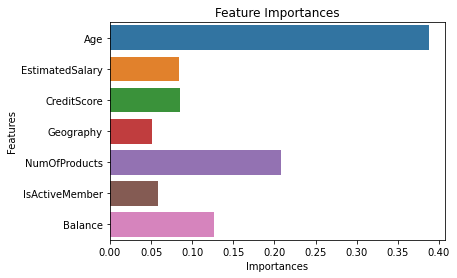

In [150]:
###########################################
### MODEL IMPLEMENTATION, RANDOM FOREST ###
###########################################

## Random Grid search has already been run, to re-run, turn runRandomGrid to True
runRandomGrid = False 

if runRandomGrid:
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(50, 500, num = 100)]
    max_depth.append(None)
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 6, 8, 10]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=43, n_jobs = -1)

    # rf_random.fit(x_train, y_train)
    rf_random.fit(X_train_SMOTE, y_train_SMOTE)
    rf_random.score(x_test, y_test)

    ### Best Params ###
    '''
    {'n_estimators': 1500,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'max_depth': 25,
    'bootstrap': False}
    '''

classifier = RandomForestClassifier(min_samples_leaf = 8, min_samples_split = 8, max_features = 'sqrt', max_depth=1500, bootstrap = False, n_estimators = 1500, random_state= 42)
classifier.fit(X_train_SMOTE, y_train_SMOTE)

print('RF Final Results on Test Data')
print('------------------------------------------------')
print('RF Test Accuracy :', classifier.score(x_test,y_test))

y_preds = classifier.predict(x_test)
f1_score = metrics.f1_score(y_test, y_preds)
rf_roc_auc = metrics.roc_auc_score(y_test, classifier.predict_proba(x_test)[:,1])
print('RF Test F1 :', f1_score)
print('RF Test AUC:', rf_roc_auc)
print('------------------------------------------------')
print(classification_report(y_test, y_preds))
print('------------------------------------------------')


for i,v in enumerate(classifier.feature_importances_):
	print('Feature: %0d, Score: %.5f' % (i,v))

featureImportanceDict = {'Features':green_area,'Importances':list(classifier.feature_importances_)}
featureImportanceDictDF = pd.DataFrame(featureImportanceDict, columns=['Features','Importances'])

sns.barplot(y='Features', x='Importances', data=featureImportanceDictDF).set_title('Feature Importances')
